In [1]:
# 授權绑定Google Drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134923 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!fusermount -u drive

fusermount: failed to unmount /content/drive: No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# 指定Google Drive雲端硬碟的根目錄(drive)
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
import os
os.chdir("drive/My Drive/Colab Notebooks")

In [7]:
!ls

 201911141HW_1_code5-2
 drive
'External data: Local Files, Drive, Sheets, and Cloud Storage'
'model-VGG16(withDA)-final.h5'
 tmp


In [0]:
base_dir = ""
from google.colab import drive, files
base_dir = "/content/drive/My Drive/Colab Notebooks/tmp/cats_and_dogs_small/"

In [9]:
print('base_dir :',base_dir,'\n')

train_dir = base_dir + "/train"
validation_dir = base_dir + "/validation"
test_dir = base_dir + "/test"

train_cats_dir = train_dir + "/cats"
train_dogs_dir = train_dir + "/dogs"
validation_cats_dir = validation_dir + "/cats"
validation_dogs_dir = validation_dir + "/dogs"
test_cats_dir = test_dir + "/cats"
test_dogs_dir = test_dir + "/dogs"
 
print('訓練用的貓照片張數:', len(os.listdir(train_cats_dir)))
print('訓練用的狗照片張數:', len(os.listdir(train_dogs_dir)))
print('驗證用的貓照片張數:', len(os.listdir(validation_cats_dir)))
print('驗證用的狗照片張數:', len(os.listdir(validation_dogs_dir)))
print('測試用的貓照片張數:', len(os.listdir(test_cats_dir)))
print('測試用的狗照片張數:', len(os.listdir(test_dogs_dir)))

base_dir : /content/drive/My Drive/Colab Notebooks/tmp/cats_and_dogs_small/ 

訓練用的貓照片張數: 1000
訓練用的狗照片張數: 1000
驗證用的貓照片張數: 500
驗證用的狗照片張數: 500
測試用的貓照片張數: 500
測試用的狗照片張數: 500


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

Using TensorFlow backend.


**VGG16 (w/o data augmentation)**

In [12]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [0]:
# 使用預先訓練的 convolutional base 萃取特徵
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print(i, end=' ') # 由於萃取需要較長的時間，我們印出 i 來檢視進度
        if i * batch_size >= sample_count:
            break
    return features, labels

In [15]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

In [0]:
# 將資料展平
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [17]:
# 建置模型
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 421us/step - loss: 0.6075 - acc: 0.6655 - val_loss: 0.4591 - val_acc: 0.8100
Epoch 2/30
2000/2000 [==============================] - 1s 258us/step - loss: 0.4330 - acc: 0.8105 - val_loss: 0.3806 - val_acc: 0.8420
Epoch 3/30
2000/2000 [==============================] - 1s 255us/step - loss: 0.3600 - acc: 0.8505 - val_loss: 0.3260 - val_acc: 0.8680
Epoch 4/30
2000/2000 [==============================] - 1s 266us/step - loss: 0.3195 - acc: 0.8635 - val_loss: 0.3048 - val_acc: 0.8810
Epoch 5/30
2000/2000 [==============================] - 0s 242us/step - loss: 0.2869 - acc: 0.8845 - val_loss: 0.2904 - val_acc: 0.8810
Epoch 6/30
2000/2000 [==============================] - 0s

In [18]:
loss, accuracy = model.evaluate(train_features, train_labels)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

2000/2000 [==============================] - 0s 73us/step

Loss: 0.07, Accuracy: 97.75%


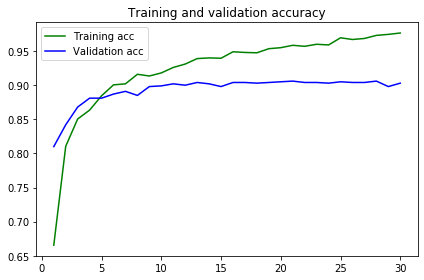

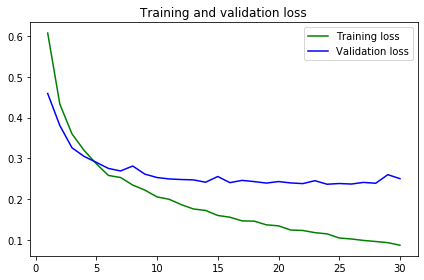

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**VGG16 (with data augmentation)**

In [20]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [21]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False  

print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [22]:
train_datagen = ImageDataGenerator(
                rescale=1./255, rotation_range=40, width_shift_range=0.2,
                height_shift_range=0.2, shear_range=0.2,
                zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                    target_size=(150, 150), batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                        validation_dir, target_size=(150, 150), 
                        batch_size=20, class_mode='binary')

model.compile( loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100,
        epochs=30, validation_data=validation_generator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 19s 190ms/step - loss: 0.5854 - acc: 0.6955 - val_loss: 0.4324 - val_acc: 0.8200
Epoch 2/30
100/100 [==============================] - 17s 172ms/step - loss: 0.4762 - acc: 0.7865 - val_loss: 0.3635 - val_acc: 0.8490
Epoch 3/30
100/100 [==============================] - 17s 170ms/step - loss: 0.4330 - acc: 0.8055 - val_loss: 0.3277 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 17s 170ms/step - loss: 0.4122 - acc: 0.8250 - val_loss: 0.3088 - val_acc: 0.8700
Epoch 5/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3906 - acc: 0.8295 - val_loss: 0.2958 - val_acc: 0.8760
Epoch 6/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3735 - acc: 0.8330 - val_loss: 0.2802 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3613 - acc: 0.8395 - val_lo

In [23]:
model.save('model-VGG16(withDA)-final.h5')
scores = model.evaluate_generator(generator=validation_generator, steps=validation_generator.samples // batch_size)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (scores[0]/100, scores[1]*100))


Loss: 0.00, Accuracy: 90.50%


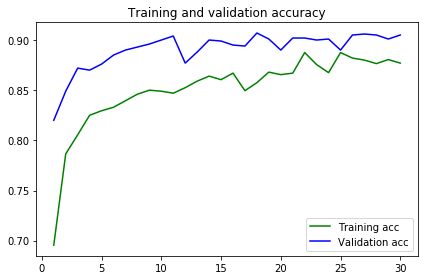

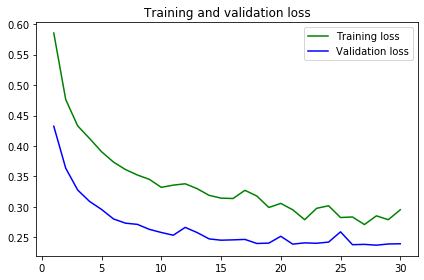

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**ResNet50**

In [0]:
import sys
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dropout, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.python.keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.initializers import glorot_uniform

In [0]:
# 資料路徑
base_dir = "/content/drive/My Drive/Colab Notebooks/tmp/cats_and_dogs_small/"
DATASET_PATH  = base_dir
# 影像大小
IMAGE_SIZE = (224, 224)
# 影像類別數
NUM_CLASSES = 2
# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 2
# 凍結網路層數
FREEZE_LAYERS = 2
# Epoch 數
NUM_EPOCHS = 20
# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

In [3]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/validation',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
def identity_block(X, f, filters,stage, block):
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  
  X_shortcut = X
  
  X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
  
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)
  
  return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
  conv_name_base = 'res' + str(stage) + block +'_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  
  X_shortcut = X
  
  X = Conv2D(F1, (1, 1), strides = (s, s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  
  X = Conv2D(F2, (f, f), strides = (1, 1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  
  X = Conv2D(F3, (1, 1), strides = (1, 1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  
  X_shortcut = Conv2D(F3, (1,1), strides=(s, s), name=conv_name_base+'1', padding='valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3, name=bn_name_base+'1')(X_shortcut)
  
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)
  
  return X

In [0]:
def ResNet50(input_shape = (32, 32, 3), classes = 10):
  X_input = Input(input_shape)
  
  X = ZeroPadding2D((3, 3))(X_input)
  
  X = Conv2D(64, (7, 7), strides=(2, 2), name = 'conv1', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2,2))(X)
  
  X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block ='a', s=1)
  X = identity_block(X, 3, [64, 64, 256], stage = 2, block = 'b')
  X = identity_block(X, 3, [64, 64, 256], stage = 2, block = 'c')
  
  X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
  X = identity_block(X, f=3, filters=[128, 128, 512], stage = 3, block = 'b')
  X = identity_block(X, f=3, filters=[128, 128, 512], stage = 3, block = 'c')
  X = identity_block(X, f=3, filters=[128, 128, 512], stage = 3, block = 'd')
  
  X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
  X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='b')
  X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='c')
  X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='d')
  X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='e')
  X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='f')
 
  X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
  X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block='b')
  X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block='c')
  
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc'+str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
  
  model = Model(inputs = X_input, outputs = X, name='ResNet50')
  
  return model

In [16]:
# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net.summary())

Class #0 = cats
Class #1 = dogs
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________

In [0]:
# 訓練模型
history = net.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net.save(WEIGHTS_FINAL)

In [0]:
scores = model.evaluate_generator(generator=validation_generator, steps=validation_generator.samples // BATCH_SIZE)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (scores[0]/100, scores[1]*100))

Loss: 0.00, Accuracy: 90.20%

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**InceptionV3**

In [0]:
import pandas as pd
import numpy as np
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras import backend as K

In [0]:
# 影像維度
img_width, img_height = 299, 299

train_data_dir = "/content/drive/My Drive/Colab Notebooks/tmp/cats_and_dogs_small/train"
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/tmp/cats_and_dogs_small/validation'
nb_train_samples = 2000
nb_validation_samples = 800
batch_size = 2

In [0]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [21]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# 添加全域空間平均池化層
x = base_model.output
x = GlobalAveragePooling2D()(x)
# 增加全連階層
x = Dense(1024, activation='relu', name='fc1')(x)
prediction = Dense(2, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=prediction)
model.summary()


87916544/87910968 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_246 (Activation)     (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________

In [0]:
# 凍結所有層(除了Bottleneck Layers以外)來進行微調
for layer in model.layers:
    if layer.name in ['predictions']:
        continue
    layer.trainable = False

In [23]:
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df

,layer,trainable
0,input_6,False
1,conv2d_1,False
2,batch_normalization_1,False
3,activation_246,False
4,conv2d_2,False
...,...,...
309,activation_339,False
310,mixed10,False
311,global_average_pooling2d_1,False
312,fc1,False


In [25]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='/content/drive/My Drive/Colab Notebooks/tmp/cats_and_dogs_small/train',
                                                    target_size=[img_width, img_height],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(directory='/content/drive/My Drive/Colab Notebooks/tmp/cats_and_dogs_small/validation',
                                                              target_size=[img_width, img_height],
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // batch_size,
        epochs = 20)

model.save('model-inceptionv3-final.h5')

Epoch 1/20
1000/1000 [==============================] - 545s 545ms/step - loss: 0.5382 - acc: 0.7045 - val_loss: 4.7802 - val_acc: 0.5790
Epoch 2/20
1000/1000 [==============================] - 533s 533ms/step - loss: 0.4874 - acc: 0.7480 - val_loss: 5.9578 - val_acc: 0.5570
Epoch 3/20
1000/1000 [==============================] - 551s 551ms/step - loss: 0.4739 - acc: 0.7605 - val_loss: 5.7360 - val_acc: 0.5500
Epoch 4/20
1000/1000 [==============================] - 535s 535ms/step - loss: 0.4768 - acc: 0.7575 - val_loss: 6.1598 - val_acc: 0.5220
Epoch 5/20
1000/1000 [==============================] - 540s 540ms/step - loss: 0.4797 - acc: 0.7460 - val_loss: 6.8160 - val_acc: 0.5060
Epoch 6/20
1000/1000 [==============================] - 540s 540ms/step - loss: 0.4722 - acc: 0.7545 - val_loss: 6.8972 - val_acc: 0.5070
Epoch 7/20
1000/1000 [==============================] - 540s 540ms/step - loss: 0.4528 - acc: 0.7660 - val_loss: 7.0098 - val_acc: 0.5000
Epoch 8/20
1000/1000 [============

In [27]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

0 input_6
1 conv2d_1
2 batch_normalization_1
3 activation_246
4 conv2d_2
5 batch_normalization_2
6 activation_247
7 conv2d_3
8 batch_normalization_3
9 activation_248
10 max_pooling2d_6
11 conv2d_4
12 batch_normalization_4
13 activation_249
14 conv2d_5
15 batch_normalization_5
16 activation_250
17 max_pooling2d_7
18 conv2d_9
19 batch_normalization_9
20 activation_254
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_252
26 activation_255
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_251
37 activation_253
38 activation_256
39 activation_257
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_261
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_259
49 activation_262
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normali

In [28]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // batch_size,
        epochs = 20)

model.save('model-inceptionv3-final2.h5')

Epoch 1/20
1000/1000 [==============================] - 1166s 1s/step - loss: 4.0847 - acc: 0.5760 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 2/20
1000/1000 [==============================] - 1125s 1s/step - loss: 0.6477 - acc: 0.6230 - val_loss: 8.0777 - val_acc: 0.4980
Epoch 3/20
1000/1000 [==============================] - 1126s 1s/step - loss: 0.5530 - acc: 0.7265 - val_loss: 8.5676 - val_acc: 0.4600
Epoch 4/20
1000/1000 [==============================] - 1152s 1s/step - loss: 0.4522 - acc: 0.7975 - val_loss: 8.0913 - val_acc: 0.4980
Epoch 5/20
1000/1000 [==============================] - 1153s 1s/step - loss: 0.3674 - acc: 0.8410 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/20
1000/1000 [==============================] - 1032s 1s/step - loss: 0.2850 - acc: 0.8740 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/20
1000/1000 [==============================] - 972s 972ms/step - loss: 0.2533 - acc: 0.8885 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/20
1000/1000 [========================

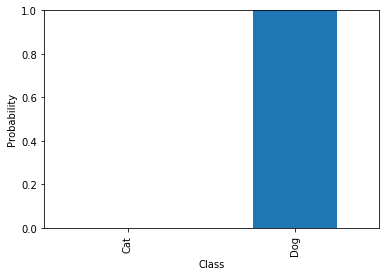

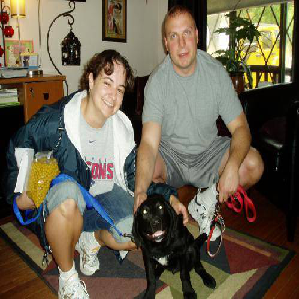

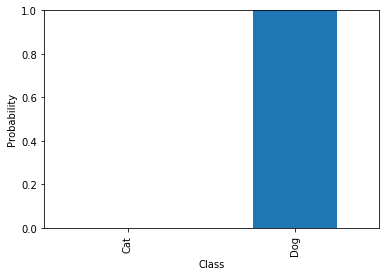

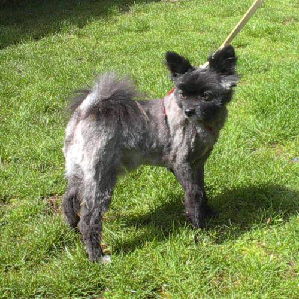

In [29]:
from IPython.display import display
import matplotlib.pyplot as plt

X_val_sample, _ = next(validation_generator)
y_pred = model.predict(X_val_sample)

nb_sample = 4
for x, y in zip(X_val_sample[:nb_sample], y_pred[:nb_sample]):
    s = pd.Series({'Cat': 1-np.max(y), 'Dog': np.max(y)})
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()

    img = array_to_img(x)
    display(img)

In [30]:
scores = model.evaluate_generator(generator=validation_generator, steps=validation_generator.samples // batch_size)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (scores[0]/100, scores[1]*100))


Loss: 0.08, Accuracy: 50.00%


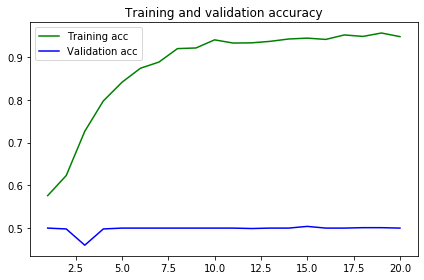

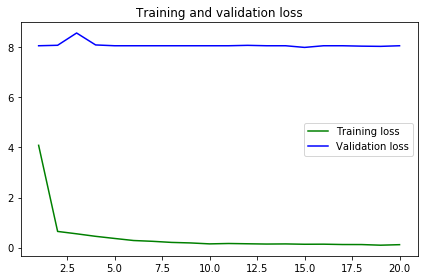

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()